In [1]:
import torch
import os, sys

sys.path.append('../')

from model.generators.enlighten_gan_generator import GeneratorEnlightenGAN
from model.discriminators.enlighten_gan_global_discriminator import GlobalDiscriminatorEnlightenGAN
from model.discriminators.enlighten_gan_local_discriminator import LocalDiscriminatorEnlightenGAN
from model.model import Model
from model.attention_map import AttentionMapGray
from model.loses.gan_loss import GanLoss
from model.vgg import Vgg16
from model.loses.vgg_loss import VGGLoss
from utils import patches
# from utils import weights
from data_loader import ABDataset

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import time
import datetime

In [2]:
device = torch.device("cuda")
netG = GeneratorEnlightenGAN()
netG.to(device)
netG = torch.nn.DataParallel(netG, device_ids=[0])

netD_global = GlobalDiscriminatorEnlightenGAN()
netD_global.to(device)
netD_global = torch.nn.DataParallel(netD_global, device_ids=[0])

num_patches = 5
netD_local = LocalDiscriminatorEnlightenGAN(n=num_patches)
netD_local.to(device)
netD_local = torch.nn.DataParallel(netD_local, device_ids=[0])

attention_map = AttentionMapGray()
criterion = GanLoss()
vgg_loss = VGGLoss()

netVgg = Vgg16()
netVgg.to(device)
model_dir = '../saved_models'
netVgg.load_state_dict(torch.load(os.path.join(model_dir, 'vgg16.weight')))
netVgg = torch.nn.DataParallel(netVgg, device_ids=[0])

model = Model(netG, netD_global, netD_local, criterion, netVgg, vgg_loss)

niter = 100
niter_decay = 100
dataset_root = '/home/student/Documents/alena/thesis/enlighte-gan-dataset'

dataset = ABDataset(dataset_root, attention_map) #,subroot_dark='dark_large', subroot_normal='normal_large')
dataset = DataLoader(dataset, batch_size=7, num_workers=1)

writer = SummaryWriter()

In [ ]:
for epoch in tqdm(range(niter + niter_decay + 1)):
    for i, data in enumerate(dataset):
        img_dark = data['dark'].to("cuda")
        img_normal = data['normal'].to("cuda")
        img_gray = data['gray'].to("cuda")

        img_generated = model.forward(img_dark, img_gray)
        with torch.no_grad():
            patches_dark_img, patches_normal_img, patches_generated_img = patches.create_patch(img_dark,
                                                                                               img_normal,
                                                                                               img_generated,
                                                                                               num_patches=num_patches)

        model.optimizer_G.zero_grad()
        lossG, loss_D_global, loss_D_local, loss_vgg = model.loss_G(img_dark, img_normal, img_generated, patches_dark_img,
                              patches_generated_img)
        lossG.backward()
        model.optimizer_G.step()

        model.optimizerD_global.zero_grad()
        lossD_global = model.loss_D_global(img_normal, img_generated.detach())
        lossD_global.backward()

        model.optimizerD_local.zero_grad()
        lossD_local = model.loss_D_local(patches_normal_img, patches_generated_img)
        lossD_local.backward()

        model.optimizerD_global.step()
        model.optimizerD_local.step()
        
    writer.add_scalar('loss G', lossG.item(), epoch)
    writer.add_scalar('loss G, global', loss_D_global.item(), epoch)
    writer.add_scalar('loss G, local', loss_D_local.item(), epoch)
    writer.add_scalar('loss G, VGG', loss_vgg.item(), epoch)
    
    writer.add_scalar('loss D global', lossD_global.item(), epoch)
    writer.add_scalar('loss D local', lossD_local.item(), epoch)
        

    if epoch > niter:
        model.update_learning_rate(niter)
writer.close()

 14%|█▍        | 28/201 [05:40<35:10, 12.20s/it]

In [ ]:
time_checkpoint = str(datetime.datetime.now())
os.mkdir('../saved_models/checkpoints/%s' % time_checkpoint)

torch.save(model.state_dict(), '../saved_models/checkpoints/%s/model' % time_checkpoint)

In [6]:
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [7]:
from utils import image_utils, image_tf
import matplotlib.pyplot as plt

(640, 480)


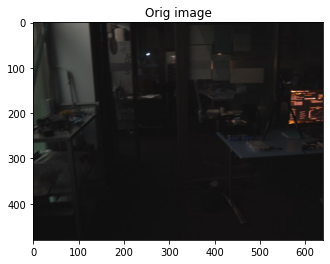

In [14]:
img_dark_orig = image_utils.load_image('/home/student/Documents/alena/thesis/enlighte-gan-dataset/test/dark/5our_data.jpeg')
plt.title('Orig image')
plt.imshow(img_dark_orig)

if img_dark_orig.size[0] > 1000 or img_dark_orig.size[1] > 1000:
    h, w = img_dark_orig.size
    img_dark_orig = img_dark_orig.resize((h//2, w//2))

img_data_cropped = image_utils.crop_image(img_dark_orig, power=16)
print(img_data_cropped.size)
    
# h, w = img_dark_orig.size
# pix_to_crop_h = h % 16
# pix_to_crop_w = w % 16
# img_data_cropped = img_dark_orig.crop((0, 0, h - pix_to_crop_h, w - pix_to_crop_w))

img_dark = image_tf.get_transforms(False, 320)(img_data_cropped)

gray = attention_map(img_dark)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


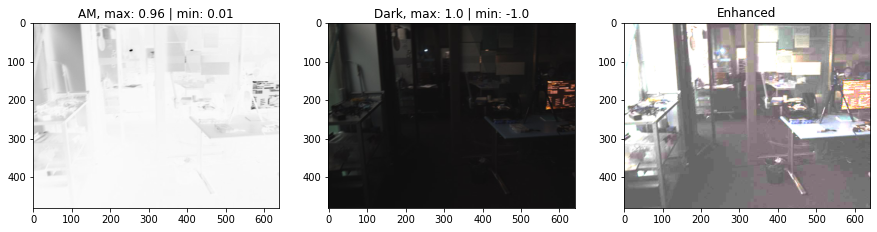

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 10))

ax[0].set_title('AM, max: ' + str(round(gray.max().item(), 2)) + " | min: " + str(round(gray.min().item(), 2)))
ax[0].imshow(gray.permute(1, 2, 0),cmap='gray')

ax[1].set_title('Dark, max: ' + str(round(img_dark.max().item(), 2)) + " | min: " + str(round(img_dark.min().item(), 2)))
ax[1].imshow((img_dark.permute(1, 2, 0) + 1) /2, cmap='gray')

ax[2].set_title('Enhanced')
ax[2].imshow((2 + img_dark.permute(1, 2, 0)) ** 3.0 - 1) 

In [10]:
# print(os.path.join(model_dir, '/checkpoints/%s/netG'%time_checkpoint))

In [11]:
time_checkpoint = '2022-01-21 02:52:41.126934'

In [8]:
device = torch.device("cuda")

netG = GeneratorEnlightenGAN()
netG.to(device)
netG = torch.nn.DataParallel(netG, device_ids=[0])

netD_global = GlobalDiscriminatorEnlightenGAN()
netD_global.to(device)
netD_global = torch.nn.DataParallel(netD_global, device_ids=[0])

netD_local = LocalDiscriminatorEnlightenGAN(n=5)
netD_local.to(device)
netD_local = torch.nn.DataParallel(netD_local, device_ids=[0])

attention_map = AttentionMapGray()
criterion = GanLoss()
vgg_loss = VGGLoss()

netVgg = Vgg16()
netVgg.to(device)
model_dir = '../saved_models'
netVgg.load_state_dict(torch.load(os.path.join(model_dir, 'vgg16.weight')))
netVgg = torch.nn.DataParallel(netVgg, device_ids=[0])

model_test = Model(netG, netD_global, netD_local, criterion, netVgg, vgg_loss)

model_test.load_state_dict(torch.load('../saved_models/checkpoints/%s/model'%time_checkpoint))

<All keys matched successfully>

In [16]:
prediction = model._netG.forward(img_dark[None, :, :, :].cuda(), gray[None, :, :, :].cuda())

max:  254.99990844726562 | min:  0.0


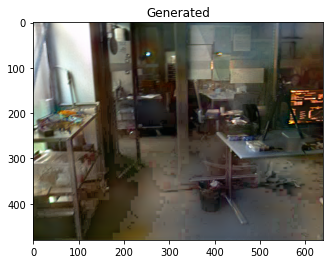

In [17]:
predicted_image = (prediction.detach().cpu()[0, :, :, :].permute(1, 2, 0) + 1 ) * 255 /2
print('max: ', predicted_image.max().item(), "| min: ", predicted_image.min().item())
plt.title('Generated')
plt.imshow(predicted_image.numpy().astype(int))